# Trabajo Práctico 1 : Reservas de Hotel


## Librerias


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
import os


np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [87]:
def mostrar_scores(y_test, y_prediccion):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

## Redes Neuronales

Importamos el dataset y las librerias necesarias para el analisis. Conservamos el mismo procesamiento de datos que en el del chapter 1.

In [88]:
df_redes = pd.read_csv('dataframe_chp1.csv')

In [89]:
df_a_utilizar = df_redes.copy()

Inicialmente vamos a utilizar el mismo dataset con las mismas features que veniamos porbando en los demas capitulos. Cabe recalcar que en un futuro quizas cambiemos estas features ya que no sabemos como se van a comportar con nuestro modelo de redes neuronales.

In [90]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [91]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_redes['reserved_room_type'] == df_redes['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Utilizamos un split de data de 0.7 para train y 0.3 para test.

In [92]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_a_utilizar["is_canceled"].values
                                                    )

Usamos el min max scaler para escalar los datos ya que esto mejora la convergencia de la red neuronal, iguala la influencia de las caracteristicas y ademas evita problemas numericos debido a que algunas funciones de activacion no trabajan muy bien si los valores de entrada son muy grandes.

In [93]:
escalador=MinMaxScaler()

x_train_escalado_min_max=pd.DataFrame(escalador.fit_transform(x_train))
x_test_escalado_min_max=pd.DataFrame(escalador.transform(x_test))

Ademas, lo bueno del min max es que nuestras variables dummies van a seguir estando exactamente igual a como estaban antes del escalado.

### Red neuronal básica

Utilizamos el optimizador de Adam ya que investigamos que es de los mejores en este aspecto, ya que combina el optimizador de RMSProp y el de descenso de gradiente estocastico (SGD). 

Epoch 1/10
1218/1218 [==============================] - 1s 616us/step - loss: 0.3872 - accuracy: 0.8150
Epoch 2/10
1218/1218 [==============================] - 1s 542us/step - loss: 0.3319 - accuracy: 0.8400
Epoch 3/10
1218/1218 [==============================] - 1s 462us/step - loss: 0.3218 - accuracy: 0.8437
Epoch 4/10
1218/1218 [==============================] - 1s 480us/step - loss: 0.3146 - accuracy: 0.8490
Epoch 5/10
1218/1218 [==============================] - 1s 608us/step - loss: 0.3085 - accuracy: 0.8508
Epoch 6/10
1218/1218 [==============================] - 1s 498us/step - loss: 0.3035 - accuracy: 0.8546
Epoch 7/10
1218/1218 [==============================] - 1s 507us/step - loss: 0.2994 - accuracy: 0.8563
Epoch 8/10
1218/1218 [==============================] - 1s 457us/step - loss: 0.2944 - accuracy: 0.8603
Epoch 9/10
1218/1218 [==============================] - 1s 459us/step - loss: 0.2902 - accuracy: 0.8638
Epoch 10/10
522/522 [==============================] - 0s 274us/

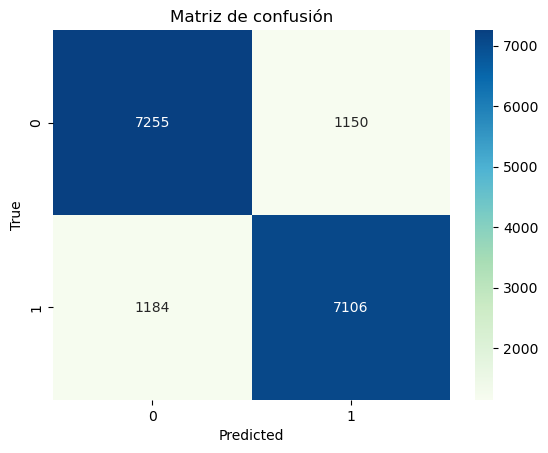

1218/1218 [==============================] - 0s 348us/step
Accuracy: 0.8699781799512257
Recall: 0.8732665039214668
Precision: 0.8649552423088795
f1 score: 0.8690910030756507


In [94]:
modelo = keras.Sequential([
   keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu'),
   keras.layers.Dense(1, activation='sigmoid')
])

modelo.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Podemos ver que el Recall es considerablemente mas elevado que el Precision, lo cual nos indica que el modelo esta prediciendo correctamente los casos negativos, pero no tanto los positivos.

### Red neuronal con capas de dropout

Ahora agregamos dropout, el cual es una tecnica de regularizacion que se utiliza en redes neuronales para evitar el overfitting.

Epoch 1/10
1218/1218 [==============================] - 1s 641us/step - loss: 0.3934 - accuracy: 0.8094
Epoch 2/10
1218/1218 [==============================] - 1s 780us/step - loss: 0.3371 - accuracy: 0.8368
Epoch 3/10
1218/1218 [==============================] - 1s 921us/step - loss: 0.3267 - accuracy: 0.8410
Epoch 4/10
1218/1218 [==============================] - 1s 517us/step - loss: 0.3189 - accuracy: 0.8457
Epoch 5/10
1218/1218 [==============================] - 1s 533us/step - loss: 0.3135 - accuracy: 0.8484
Epoch 6/10
1218/1218 [==============================] - 1s 554us/step - loss: 0.3083 - accuracy: 0.8526
Epoch 7/10
1218/1218 [==============================] - 1s 479us/step - loss: 0.3042 - accuracy: 0.8543
Epoch 8/10
1218/1218 [==============================] - 1s 638us/step - loss: 0.2997 - accuracy: 0.8564
Epoch 9/10
1218/1218 [==============================] - 1s 525us/step - loss: 0.2964 - accuracy: 0.8600
Epoch 10/10
522/522 [==============================] - 0s 283us/

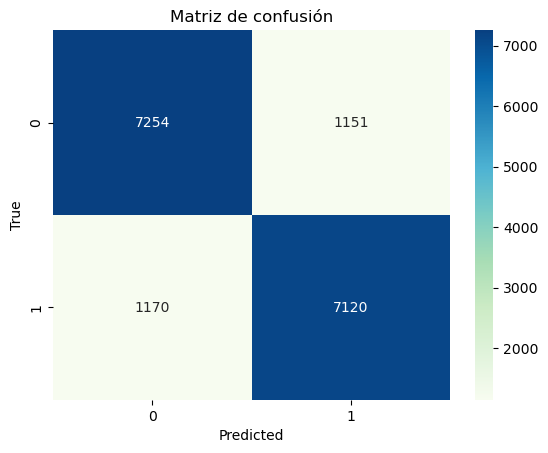

1218/1218 [==============================] - 0s 323us/step
Accuracy: 0.8690283660634065
Recall: 0.8726432244325559
Precision: 0.8637602179836512
f1 score: 0.868178999586606


In [95]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

En este caso nos presentamos con el mismo problema que el modelo anterior, donde el recall es mucho mas alto que el precision. Cabe destacar que el conjunto de train es mas cercano en f1 al conjunto de test que el modelo anterior, indicando menos overfitting.

### Redes neuronales con capas de dropout, regularizacion L1 y L2

La regularizacion l1 y l2 tambien son tecnicas de regularizacion que se utilizan para evitar el overfitting. La regularizacion l1 es la suma de los valores absolutos de los coeficientes multiplicados por un factor lambda. La regularizacion l2 es la suma de los valores al cuadrado de los coeficientes multiplicados por un factor lambda.

#### Con L2 y dropout

Epoch 1/10
1218/1218 [==============================] - 1s 545us/step - loss: 0.4388 - accuracy: 0.8077
Epoch 2/10
1218/1218 [==============================] - 1s 538us/step - loss: 0.3797 - accuracy: 0.8316
Epoch 3/10
1218/1218 [==============================] - 1s 531us/step - loss: 0.3704 - accuracy: 0.8341
Epoch 4/10
1218/1218 [==============================] - 1s 510us/step - loss: 0.3637 - accuracy: 0.8359
Epoch 5/10
1218/1218 [==============================] - 1s 546us/step - loss: 0.3600 - accuracy: 0.8377
Epoch 6/10
1218/1218 [==============================] - 1s 611us/step - loss: 0.3571 - accuracy: 0.8401
Epoch 7/10
1218/1218 [==============================] - 1s 606us/step - loss: 0.3547 - accuracy: 0.8408
Epoch 8/10
1218/1218 [==============================] - 1s 678us/step - loss: 0.3516 - accuracy: 0.8429
Epoch 9/10
1218/1218 [==============================] - 1s 751us/step - loss: 0.3505 - accuracy: 0.8433
Epoch 10/10
522/522 [==============================] - 0s 282us/

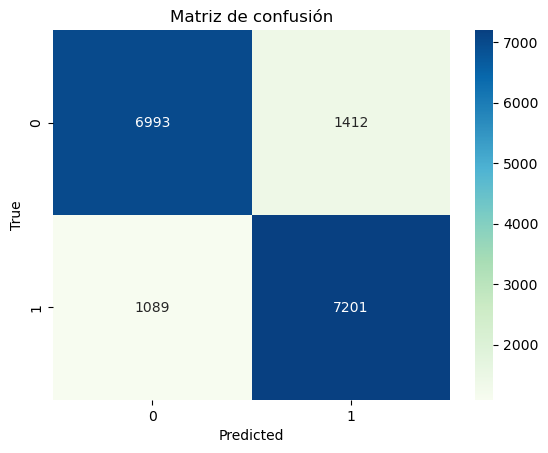

1218/1218 [==============================] - 0s 334us/step
Accuracy: 0.8521627518932101
Recall: 0.876175141536384
Precision: 0.8332839359810315
f1 score: 0.8541914575790567


In [96]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',   
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())


#### Con L1 y dropout

Epoch 1/10
1218/1218 [==============================] - 1s 601us/step - loss: 0.5929 - accuracy: 0.7914
Epoch 2/10
1218/1218 [==============================] - 1s 559us/step - loss: 0.4501 - accuracy: 0.8178
Epoch 3/10
1218/1218 [==============================] - 1s 529us/step - loss: 0.4314 - accuracy: 0.8227
Epoch 4/10
1218/1218 [==============================] - 1s 541us/step - loss: 0.4187 - accuracy: 0.8252
Epoch 5/10
1218/1218 [==============================] - 1s 501us/step - loss: 0.4112 - accuracy: 0.8282
Epoch 6/10
1218/1218 [==============================] - 1s 516us/step - loss: 0.4059 - accuracy: 0.8299
Epoch 7/10
1218/1218 [==============================] - 1s 501us/step - loss: 0.4032 - accuracy: 0.8299
Epoch 8/10
1218/1218 [==============================] - 1s 641us/step - loss: 0.3986 - accuracy: 0.8333
Epoch 9/10
1218/1218 [==============================] - 1s 506us/step - loss: 0.3955 - accuracy: 0.8325
Epoch 10/10
522/522 [==============================] - 0s 279us/

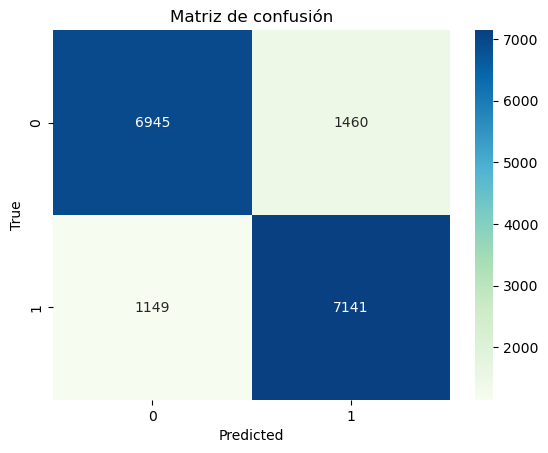

1218/1218 [==============================] - 0s 280us/step
Accuracy: 0.8428186368887177
Recall: 0.862930452397029
Precision: 0.8266494178525227
f1 score: 0.844400396432111


In [97]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

En este caso la diferencia entre Recall y Precision en muchisimo mas elevada, esto puede ser debido a la regularizacion.

#### Con dropout, L1 y L2

Epoch 1/10
1218/1218 [==============================] - 1s 556us/step - loss: 0.6021 - accuracy: 0.7927
Epoch 2/10
1218/1218 [==============================] - 1s 540us/step - loss: 0.4554 - accuracy: 0.8183
Epoch 3/10
1218/1218 [==============================] - 1s 521us/step - loss: 0.4382 - accuracy: 0.8223
Epoch 4/10
1218/1218 [==============================] - 1s 536us/step - loss: 0.4280 - accuracy: 0.8244
Epoch 5/10
1218/1218 [==============================] - 1s 521us/step - loss: 0.4204 - accuracy: 0.8257
Epoch 6/10
1218/1218 [==============================] - 1s 545us/step - loss: 0.4150 - accuracy: 0.8259
Epoch 7/10
1218/1218 [==============================] - 1s 519us/step - loss: 0.4111 - accuracy: 0.8263
Epoch 8/10
1218/1218 [==============================] - 1s 513us/step - loss: 0.4062 - accuracy: 0.8291
Epoch 9/10
1218/1218 [==============================] - 1s 520us/step - loss: 0.4029 - accuracy: 0.8312
Epoch 10/10
522/522 [==============================] - 0s 275us/

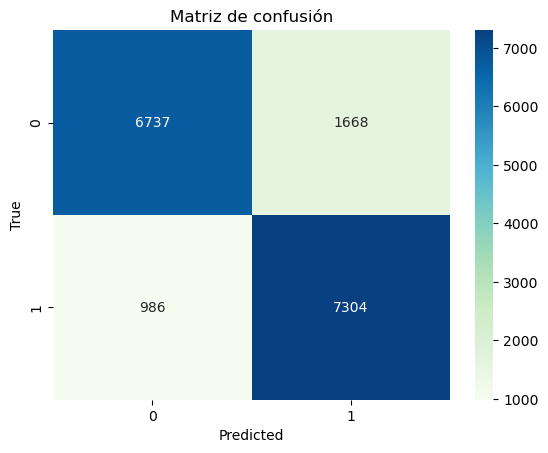

1218/1218 [==============================] - 0s 283us/step
Accuracy: 0.8403029136182775
Recall: 0.8850049342959538
Precision: 0.8096075263708068
f1 score: 0.8456289237946351


In [98]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Notamos la misma diferencia que en el caso anterior, confirmando la teoria que es la regularizacion.

### Red neuronal con batch normalization

Esta nueva caracteristica, batch normalization, leimos que ayuda a mejorar la velocidad de convergencia y estabilidad del algortimo. 

Epoch 1/10
1218/1218 [==============================] - 1s 615us/step - loss: 0.6970 - accuracy: 0.8056
Epoch 2/10
1218/1218 [==============================] - 1s 596us/step - loss: 0.4572 - accuracy: 0.8209
Epoch 3/10
1218/1218 [==============================] - 1s 616us/step - loss: 0.4292 - accuracy: 0.8222
Epoch 4/10
1218/1218 [==============================] - 1s 591us/step - loss: 0.4148 - accuracy: 0.8262
Epoch 5/10
1218/1218 [==============================] - 1s 613us/step - loss: 0.4091 - accuracy: 0.8302
Epoch 6/10
1218/1218 [==============================] - 1s 587us/step - loss: 0.4034 - accuracy: 0.8318
Epoch 7/10
1218/1218 [==============================] - 1s 617us/step - loss: 0.4018 - accuracy: 0.8310
Epoch 8/10
1218/1218 [==============================] - 1s 611us/step - loss: 0.3995 - accuracy: 0.8317
Epoch 9/10
1218/1218 [==============================] - 1s 655us/step - loss: 0.3978 - accuracy: 0.8321
Epoch 10/10
522/522 [==============================] - 0s 288us/

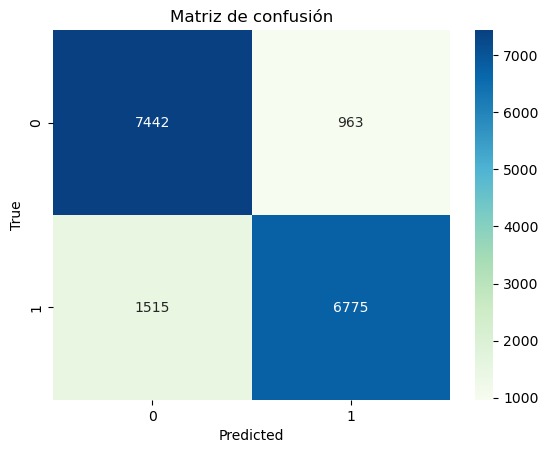

1218/1218 [==============================] - 0s 314us/step
Accuracy: 0.8508792196123732
Recall: 0.8188853685139978
Precision: 0.8716275984077841
f1 score: 0.8444337323585336


In [99]:
modelo = keras.Sequential([

    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Este es el primer caso donde la precision es mayor que el recall, mirando la matriz de confusion podemos observar tambien que nuestro modelo tiene a predecir mas casos negativos que positivos.

### Red neuronal con early stopping

El early stopping es otro parametro para evitar el overfit. La idea de esto es que si el modelo no mejora despues de cierta cantidad de epochs, se detiene el entrenamiento.

Epoch 1/10
1218/1218 [==============================] - 1s 633us/step - loss: 0.6725 - accuracy: 0.8061
Epoch 2/10
1218/1218 [==============================] - 1s 649us/step - loss: 0.4528 - accuracy: 0.8213
Epoch 3/10
1218/1218 [==============================] - 1s 592us/step - loss: 0.4289 - accuracy: 0.8243
Epoch 4/10
1218/1218 [==============================] - 1s 594us/step - loss: 0.4174 - accuracy: 0.8263
Epoch 5/10
1218/1218 [==============================] - 1s 636us/step - loss: 0.4100 - accuracy: 0.8299
Epoch 6/10
1218/1218 [==============================] - 1s 615us/step - loss: 0.4021 - accuracy: 0.8287
Epoch 7/10
1218/1218 [==============================] - 1s 623us/step - loss: 0.4021 - accuracy: 0.8302
Epoch 8/10
1218/1218 [==============================] - 1s 583us/step - loss: 0.4007 - accuracy: 0.8324
Epoch 9/10
1218/1218 [==============================] - 1s 587us/step - loss: 0.3981 - accuracy: 0.8320
Epoch 10/10
522/522 [==============================] - 0s 295us/

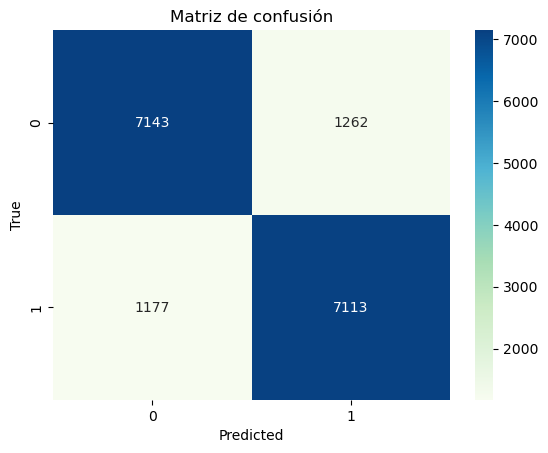

1218/1218 [==============================] - 0s 295us/step
Accuracy: 0.8542420741881658
Recall: 0.8621513530358905
Precision: 0.845895123069867
f1 score: 0.8539458792056797


In [100]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

modelo.fit(x_train_escalado_min_max, y_train, epochs=10, callbacks=[early_stopping])

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Aqui podemos notar el mismo caso que el del modelo anterior pero aun mas acentuado, donde la precision es mucho mas alta que el recall.

### Red neuronal con learning rate

Por ultimo, agregamos el learning rate el cual es clave para las redes neuronales. Este parametro es el que determina el tamaño del paso que se da en cada iteracion mientras se busca un minimo de la funcion de perdida. Si el learning rate es muy pequeño, el entrenamiento va a ser muy lento. Si el learning rate es muy grande, el entrenamiento puede no converger o incluso diverger.

Epoch 1/20
1218/1218 [==============================] - 1s 619us/step - loss: 0.6569 - accuracy: 0.8122
Epoch 2/20
1218/1218 [==============================] - 1s 772us/step - loss: 0.4475 - accuracy: 0.8242
Epoch 3/20
1218/1218 [==============================] - 1s 597us/step - loss: 0.4236 - accuracy: 0.8269
Epoch 4/20
1218/1218 [==============================] - 1s 674us/step - loss: 0.4130 - accuracy: 0.8293
Epoch 5/20
1218/1218 [==============================] - 1s 588us/step - loss: 0.4084 - accuracy: 0.8302
Epoch 6/20
1218/1218 [==============================] - 1s 760us/step - loss: 0.4024 - accuracy: 0.8304
Epoch 7/20
1218/1218 [==============================] - 1s 600us/step - loss: 0.3994 - accuracy: 0.8328
Epoch 8/20
1218/1218 [==============================] - 1s 588us/step - loss: 0.3987 - accuracy: 0.8335
Epoch 9/20
1218/1218 [==============================] - 1s 584us/step - loss: 0.3944 - accuracy: 0.8337
Epoch 10/20
1218/1218 [==============================] - 1s 602u

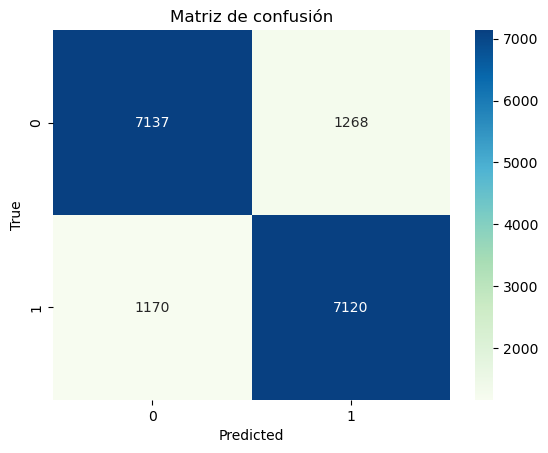

1218/1218 [==============================] - 0s 298us/step
Accuracy: 0.8535489667565139
Recall: 0.8633459720563029
Precision: 0.843927701056052
f1 score: 0.8535264063262213


In [101]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=20)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Aqui volvemos al caso inverso, donde no solo el recall es mayor, sino que tambien  hay mas casos en general catalogados como cancelados

Con esto podemos observar como el loss va disminuyendo a medida que pasan los epochs.

Epoch 1/50
   1/1218 [..............................] - ETA: 2s - loss: 0.3701 - accuracy: 0.8438

1218/1218 [==============================] - 1s 612us/step - loss: 0.3933 - accuracy: 0.8334
Epoch 2/50
1218/1218 [==============================] - 1s 624us/step - loss: 0.3907 - accuracy: 0.8362
Epoch 3/50
1218/1218 [==============================] - 1s 601us/step - loss: 0.3923 - accuracy: 0.8349
Epoch 4/50
1218/1218 [==============================] - 1s 598us/step - loss: 0.3916 - accuracy: 0.8331
Epoch 5/50
1218/1218 [==============================] - 1s 641us/step - loss: 0.3930 - accuracy: 0.8333
Epoch 6/50
1218/1218 [==============================] - 1s 724us/step - loss: 0.3910 - accuracy: 0.8338
Epoch 7/50
1218/1218 [==============================] - 1s 602us/step - loss: 0.3902 - accuracy: 0.8360
Epoch 8/50
1218/1218 [==============================] - 1s 598us/step - loss: 0.3931 - accuracy: 0.8346
Epoch 9/50
1218/1218 [==============================] - 1s 610us/step - loss: 0.3920 - accuracy: 0.8336
Epoch 10/50
1218/1218 [==============================] - 1s 603us/step - lo

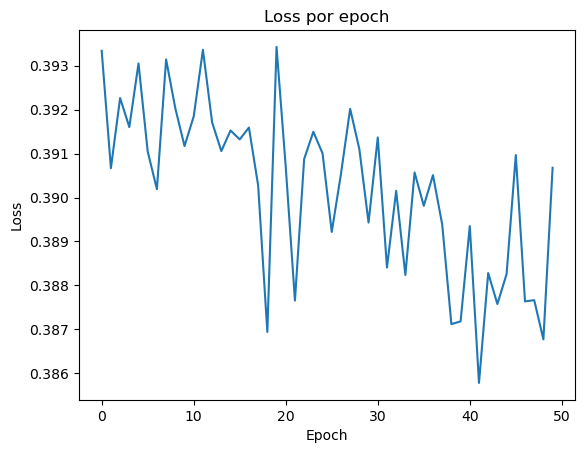

In [102]:
history = modelo.fit(x_train_escalado_min_max, y_train, epochs=50, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.title('Loss por epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Red neuronal con regularizador L2 y optimizador de Descenso por Gradiente Estocastico con learning rate

Probamos con el optimizador de SGD ya que es el mas basico y en algunos casos puede llegar a obtener mejores resultados que el de Adam.

Epoch 1/60
1218/1218 [==============================] - 1s 452us/step - loss: 0.6746 - accuracy: 0.7239
Epoch 2/60
1218/1218 [==============================] - 1s 484us/step - loss: 0.5577 - accuracy: 0.7874
Epoch 3/60
1218/1218 [==============================] - 1s 481us/step - loss: 0.5161 - accuracy: 0.8036
Epoch 4/60
1218/1218 [==============================] - 1s 460us/step - loss: 0.4956 - accuracy: 0.8119
Epoch 5/60
1218/1218 [==============================] - 1s 452us/step - loss: 0.4826 - accuracy: 0.8178
Epoch 6/60
1218/1218 [==============================] - 1s 448us/step - loss: 0.4732 - accuracy: 0.8221
Epoch 7/60
1218/1218 [==============================] - 1s 438us/step - loss: 0.4651 - accuracy: 0.8242
Epoch 8/60
1218/1218 [==============================] - 1s 439us/step - loss: 0.4581 - accuracy: 0.8261
Epoch 9/60
1218/1218 [==============================] - 1s 462us/step - loss: 0.4519 - accuracy: 0.8273
Epoch 10/60
1218/1218 [==============================] - 1s 439u

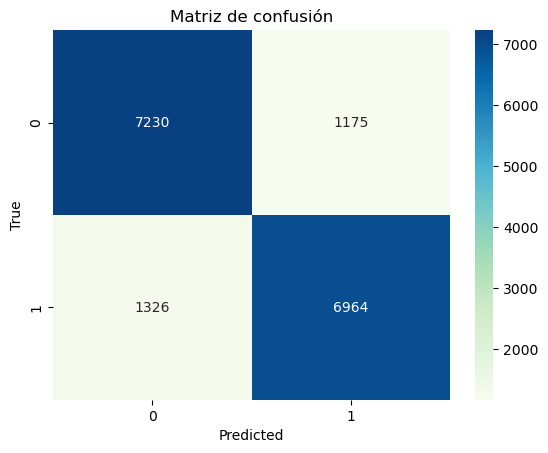

1218/1218 [==============================] - 0s 302us/step
Accuracy: 0.8507765370299063
Recall: 0.8453747467927076
Precision: 0.8516115529510255
f1 score: 0.8484816890394891


In [103]:
modelo = keras.Sequential([
   keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0004)),
   keras.layers.Dense(1, activation='sigmoid'),

])

modelo.compile(optimizer=keras.optimizers.legacy.SGD(learning_rate=0.01),
             loss='binary_crossentropy',
             metrics=['accuracy'], 
             
             )

modelo.fit(x_train_escalado_min_max, y_train, epochs=60)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Como podemos ver este modelo esta bastante balanceado, sin embargo no predice muy bien en general.

### Busqueda de hiperparams

In [104]:
def crear_modelo(optimizer='adam', kernel_initializer='glorot_uniform', activation='relu', neurons=1):
    modelo = keras.Sequential([
        keras.layers.Dense(neurons, input_shape=(x_train_escalado_min_max.shape[1],), activation=activation, kernel_initializer=kernel_initializer),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')

    ])

    modelo.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    return modelo

modelo = KerasClassifier(build_fn=crear_modelo, verbose=0)

param_grid = {

    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 50, 100],
    'optimizer': ['adam'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'neurons': [128, 256, 512],
    'kernel_initializer': ['glorot_uniform', 'normal', 'uniform']
}

random_search = RandomizedSearchCV(modelo, param_grid, cv=5, n_iter=10, scoring='accuracy', verbose=10, n_jobs=-1)
random_search.fit(x_train_escalado_min_max, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 3/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=normal, neurons=512, optimizer=adam
[CV 1/5; 1/10] START activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam[CV 2/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=normal, neurons=512, optimizer=adam

[CV 2/5; 1/10] START activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam
[CV 1/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=normal, neurons=512, optimizer=adam
[CV 4/5; 1/10] START activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam
[CV 3/5; 1/10] START activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam
[CV 5/5; 1/10] START activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam


2023-11-02 17:14:22.305978: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.313314: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.315051: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.337521: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.358873: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.361144: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.375206: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 17:14:22.381993: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


244/244 [==============================] - 1s 3ms/step
[CV 3/5; 1/10] END activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam;, score=0.829 total time=  12.6s
[CV 1/5; 1/10] END activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam;, score=0.843 total time=  12.6s
[CV 5/5; 1/10] END activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam;, score=0.834 total time=  12.6s
[CV 4/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=normal, neurons=512, optimizer=adam
[CV 2/5; 1/10] END activation=tanh, batch_size=128, epochs=10, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam;, score=0.829 total time=  12.7s
[CV 5/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=normal, neurons=512, optimizer=adam
[CV 1/5; 3/10] START activation=sigmoid, batch_size=128, epochs=50, ker

Luego de esta busqueda podemos ver los  resultados de este nuevo modelo tanto con los datos de train y los de test, para ver si realmente hay una mejora y si el modelo no esta overfiteado.

522/522 [==============================] - 0s 727us/step
Accuracy: 0.8619347109913148
Recall: 0.8697225572979493
Precision: 0.8547717842323651
f1 score: 0.8621823617339311


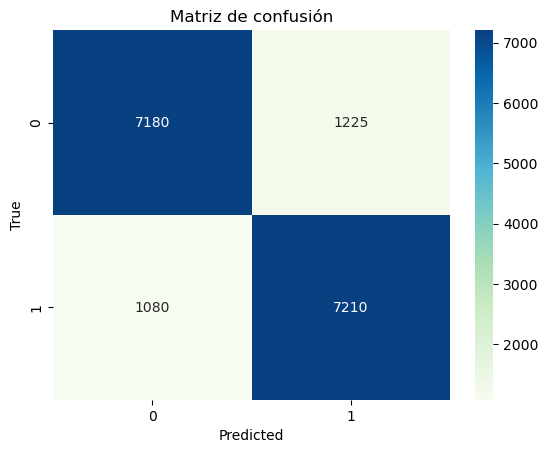

1218/1218 [==============================] - 1s 521us/step
Accuracy: 0.9078937235271467
Recall: 0.9182984469952734
Precision: 0.8976897689768977
f1 score: 0.9078771695594124


In [105]:
y_prediccion = random_search.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion)

tabla = confusion_matrix(y_test, y_prediccion)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = random_search.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train)

En este modelo ambas metricas estan balanceadas, sin embargo presenta cierto overfitting, vamos a ver si podemos mejorar eso manteniendo el balance de las metricas.

### Armado del mejor modelo

Luego de haber testeado con multiples parametros, vamos a crear una red neuronales tomando los que mejor resultados nos den y predictear a kaggle.

Epoch 1/60
1218/1218 [==============================] - 1s 888us/step - loss: 0.4077 - accuracy: 0.8183
Epoch 2/60
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3617 - accuracy: 0.8367
Epoch 3/60
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3524 - accuracy: 0.8408
Epoch 4/60
1218/1218 [==============================] - 1s 990us/step - loss: 0.3463 - accuracy: 0.8426
Epoch 5/60
1218/1218 [==============================] - 1s 967us/step - loss: 0.3414 - accuracy: 0.8452
Epoch 6/60
1218/1218 [==============================] - 1s 682us/step - loss: 0.3378 - accuracy: 0.8483
Epoch 7/60
1218/1218 [==============================] - 1s 902us/step - loss: 0.3350 - accuracy: 0.8480
Epoch 8/60
1218/1218 [==============================] - 1s 583us/step - loss: 0.3317 - accuracy: 0.8513
Epoch 9/60
1218/1218 [==============================] - 1s 811us/step - loss: 0.3286 - accuracy: 0.8539
Epoch 10/60
1218/1218 [==============================] - 1s 678us/st

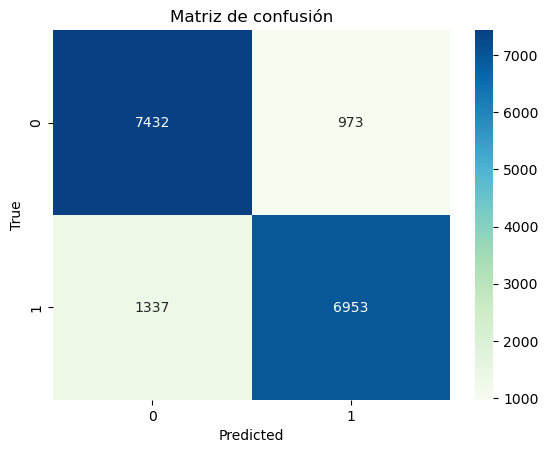

1218/1218 [==============================] - 0s 351us/step
Accuracy: 0.8795276601206521
Recall: 0.8617358333766166
Precision: 0.8909354526903662
f1 score: 0.876092409240924


In [106]:
modelo = keras.Sequential([
   keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0004)),
   keras.layers.Dense(1, activation='sigmoid'),

])

modelo.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=60)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())
tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Como podemos ver el modelo empeoro tanto en el f1 score, como el balanceo y el overfitting, vamos a probar con otro modelo.

#### Red neuronal con muchas capas y dropout


Vamos a probar agregando mas capas y epochs para ver si mejora el modelo, para evitar el overfitting realizamos dropouts.

Epoch 1/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.4661 - accuracy: 0.8209
Epoch 2/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3940 - accuracy: 0.8384
Epoch 3/50
1218/1218 [==============================] - 2s 2ms/step - loss: 0.3716 - accuracy: 0.8437
Epoch 4/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3588 - accuracy: 0.8482
Epoch 5/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3502 - accuracy: 0.8522
Epoch 6/50
1218/1218 [==============================] - 2s 2ms/step - loss: 0.3450 - accuracy: 0.8537
Epoch 7/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3427 - accuracy: 0.8534
Epoch 8/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3395 - accuracy: 0.8552
Epoch 9/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3381 - accuracy: 0.8558
Epoch 10/50
1218/1218 [==============================] - 2s 2ms/step - loss: 0.333

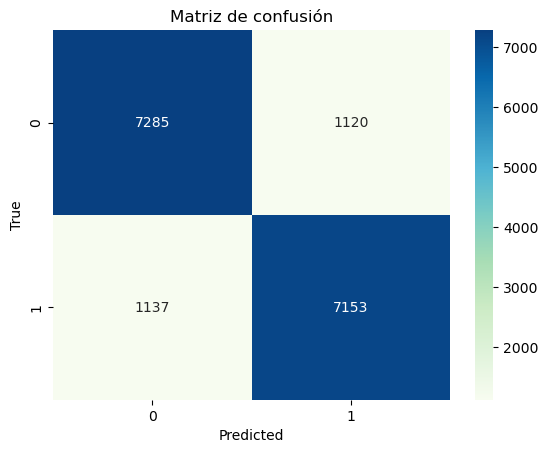

1218/1218 [==============================] - 1s 450us/step
Accuracy: 0.8771659607239122
Recall: 0.8797589985976212
Precision: 0.8727328936521023
f1 score: 0.8762318615659193


In [107]:
modelo = keras.Sequential([
    keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.00004, 0.0005), kernel_initializer='normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(0.00004)),
    keras.layers.Dense(64, activation='relu',  kernel_regularizer=keras.regularizers.l1(0.00004)),
    keras.layers.Dense(1, activation='sigmoid'),
    
    ])

modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=50)
y_prediccion = modelo.predict(x_test_escalado_min_max)

mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)

mostrar_scores(y_train, y_prediccion_train.round())



En nuestro modelo final podemos ver como a pesar que haya cierto overfitting, el recall y precision son muy similares, al igual con el f1, y la cantidad de positivos y negativos esta equitativamente balanceada.

## Evaluación con el dataset de test

In [108]:
df_test = pd.read_csv('https://drive.usercontent.google.com/download?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download&authuser=0&confirm=t&uuid=2892328a-d7d8-47c7-98e1-3e69ef723100&at=APZUnTU5aCf9tHsTaF3PM7aD9Lym:1695760323667')

df_test.shape

(26535, 31)

### Imputacion de valores faltantes

Primero imputamos el dataset tal cual lo hicimos con el de train, sin inspeccionar casos bordes para evitar data leakage.

In [109]:
nuevas_columnas = {
    'arrival_date_year' : 'year',
    'arrival_date_month' : 'month',
    'arrival_date_week_number' : 'week_number',
    'arrival_date_day_of_month' : 'day_of_month',
    'meal' : 'meal_type',
    'agent' : 'agent_id',
    'adr' : 'average_daily_rate'
}
df_test.rename(columns = nuevas_columnas, inplace = True)

Imputación de children, company y adults

In [110]:
df_test['total_nights'] = df_test['stays_in_week_nights'] + df_test['stays_in_weekend_nights']
df_test['children'].fillna(0, inplace=True)
df_test['total_people'] = df_test['adults'] + df_test['children'] + df_test['babies']
df_test['meal_type'].replace(['SC', 'Undefined'], 'NoMeal', inplace=True)
df_test.drop(columns=['company'], inplace=True)

Imputación de agent id

In [111]:
for index, row in df_test.iterrows():
    if (pd.isna(row['agent_id'])) & (row['distribution_channel'] == 'Direct'):
        df_test.loc[index, 'agent_id'] = -1

for index, row in df_test.iterrows():
    if (not pd.isna(row['agent_id'])) or (row['distribution_channel'] == 'Direct'):
        continue
    if row['hotel'] == 'City Hotel':
        if row['country'] == 'PRT':
            df_test.loc[index, 'agent_id'] = 1.0
        else: 
            df_test.loc[index, 'agent_id'] = 9.0
    else:
        df_test.loc[index, 'agent_id'] = 240.0

Imputación de country

In [112]:
for index, row in df_test.iterrows():
    if pd.isna(row['country']) and row['deposit_type'] == 'Non Refund':
        df_test.loc[index, 'country'] = 'PRT'

for index, row in df_test.iterrows():
    if pd.isna(row['country']) and (row['market_segment'] == 'Corporate' or row['market_segment'] == 'Offline TA/TO' or row['market_segment'] == 'Direct'):
        df_test.loc[index, 'country'] = 'PRT'

Prediccion final

In [113]:
df_encode = df_test.copy()

df_encode['agent_id'] = df_test['agent_id'].apply(lambda x: x if x in list(df_agentes_mayoritarios['agent_id']) else 'Otros')
df_encode['country'] = df_test['country'].apply(lambda x: x if x in list(df_paises_mayoritarios['country']) else 'Otros')

columns.remove('is_canceled')
df_filtrado = df_encode[columns]
columns.append('is_canceled')
df_test_con_dummies = pd.get_dummies(df_filtrado, columns=dummy_columns, drop_first=True).reset_index(drop=True)

df_test_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_test_con_dummies['cuarto_correcto'] = df_test_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)




In [114]:
mejor_modelo = modelo

test_scaled = escalador.transform(df_test_con_dummies)
y_pred= mejor_modelo.predict(test_scaled)

y_pred_int  = y_pred.round().astype(int)

df_prediccion = pd.DataFrame(y_pred_int, columns=['is_canceled'])
df_prediccion['id'] = df_test['id']
df_prediccion = df_prediccion[['id', 'is_canceled']]


df_prediccion.to_csv('prediccion.csv', index=False)

830/830 [==============================] - 0s 356us/step
